In [2]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import string
import re

import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models.fasttext import FastText
import numpy as np
import hdbscan
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

In [3]:
reviews = pd.read_csv("../project_data/reviews_for_vader.csv").drop('Unnamed: 0', axis=1)
#products = pd.read_csv("../project_data/products_clean.csv").drop('Unnamed: 0', axis=1)
sentiment = SentimentIntensityAnalyzer()

## Final Data Preparation
#### 1. VADER compund scores

In [5]:
# removing new line characters 
def preprocess(text):
    text = text.replace('\n', ' ')
    return text

reviews['reviewText'] = reviews['reviewText'].apply(preprocess)

In [99]:
# apply VADER sentiment scoring to reviews
reviews['sentiment'] = reviews['reviewText'].apply(lambda text : sentiment.polarity_scores(text))

In [7]:
# sample of reviews with vader scores
reviews[["reviewText","sentiment"]].head()

,reviewText,sentiment
0,"Positives: Comfortable chair, and a fairly goo...","{'neg': 0.03, 'neu': 0.795, 'pos': 0.176, 'com..."
1,"While this chair is very nice, unfortunately, ...","{'neg': 0.066, 'neu': 0.837, 'pos': 0.097, 'co..."
2,Great chair. I had one for about 8 years and d...,"{'neg': 0.064, 'neu': 0.849, 'pos': 0.087, 'co..."
3,"As I spent a great deal of time at my desk, I ...","{'neg': 0.028, 'neu': 0.699, 'pos': 0.272, 'co..."
4,Chairs are very individual. This one is not c...,"{'neg': 0.034, 'neu': 0.828, 'pos': 0.137, 'co..."


In [8]:
# sample of single compound sentiment score
reviews["sentiment"][0].get("compound")

0.9649

In [9]:
# function to normalize VADER compound scores to compare to customer rating

def transform_vader(score):
    limits = [-1,-0.6,-0.2,0.2,0.6,1]

    for i in range(1, len(limits)):
        if limits[i-1] <= score < limits[i]:
            return i
    if score == 1:
        return 5
    elif score == -1:
        return 1
    
    return None


In [10]:
# function to feed VADER compound scores into normalization function

def compound_to_norm(dict):
    score = dict.get('compound')
    return transform_vader(score)*1.0

In [11]:
reviews['vader_norm_scores'] = reviews['sentiment'].apply(lambda x: compound_to_norm(x))

In [12]:
reviews.head()

,asin,reviewerID,overall,summary,reviewText,sentiment,vader_norm_scores
0,B00006GNTW,A42S4C3S6QJZ,4.0,In which an office chair is reviewed,"Positives: Comfortable chair, and a fairly goo...","{'neg': 0.03, 'neu': 0.795, 'pos': 0.176, 'com...",5.0
1,B00006GNTW,A1H3VC2Y9GIJVM,3.0,Doesn't feel like a HON!!!,"While this chair is very nice, unfortunately, ...","{'neg': 0.066, 'neu': 0.837, 'pos': 0.097, 'co...",5.0
2,B00006GNTW,A3DF1AE47RDU7B,5.0,Best chair you can buy,Great chair. I had one for about 8 years and d...,"{'neg': 0.064, 'neu': 0.849, 'pos': 0.087, 'co...",3.0
3,B00006GNTW,A3RN703LRMI84G,5.0,A happy purchase,"As I spent a great deal of time at my desk, I ...","{'neg': 0.028, 'neu': 0.699, 'pos': 0.272, 'co...",5.0
4,B00006GNTW,A1F0ITW7KPUKQI,1.0,Not Comfortable For Me,Chairs are very individual. This one is not c...,"{'neg': 0.034, 'neu': 0.828, 'pos': 0.137, 'co...",5.0


#### 2. text preprocessing

In [13]:
# text preprocessing for vectorization with fasttext. case normalization, punctuation, and number removal
def preprocess(text):
    text = text.translate(str.maketrans('','', string.punctuation))
    text = re.sub(r'\d+','',text)
    text = text.lower()
    text = re.sub(' +',' ', text)
    text = text.strip()
    if len(text) > 0:
        return text
    return None

In [46]:
# preprocessing and removing rows which now have a null value in 'reviewText_clean' after preprocessing

reviews['reviewText_clean_withstpwrds'] = reviews['reviewText'].apply(lambda text: preprocess(text))

reviews.dropna(subset=['reviewText_clean_withstpwrds'], inplace=True)

reviews.reset_index(inplace=True)


In [76]:
# adding column with no stopwords

from nltk.corpus import stopwords

def remove_stopwords(text):
    nltk_stpwrds = stopwords.words('english')
    addl_stpwrds = ['chair','chairs']
    stop_words = set(nltk_stpwrds+addl_stpwrds)
    words = [word for word in text.split() if word not in stop_words]
    return ' '.join(words)

reviews['reviewText_clean_nostpwrds'] = reviews['reviewText_clean_withstpwrds'].apply(lambda text: remove_stopwords(text))
reviews.dropna(subset=['reviewText_clean_nostpwrds'], inplace=True)

#reviews.reset_index(inplace=True)

In [79]:
reviews.reset_index(inplace=True,drop=True)

In [77]:
reviews[['reviewText','reviewText_clean_withstpwrds','reviewText_clean_nostpwrds']].head()

,reviewText,reviewText_clean_withstpwrds,reviewText_clean_nostpwrds
0,"Positives: Comfortable chair, and a fairly good value for the price--I work from home a lot, so a good office chair is vital. The chair that this one replaced lasted 15 years; hopefully this one will have a similar lifespan. The armrests are shaped, padded, and positioned well. Casters roll smoothly on carpet. Padding on seat and back is thick and seems resilient so far. The outer fabric also ...",positives comfortable chair and a fairly good value for the pricei work from home a lot so a good office chair is vital the chair that this one replaced lasted years hopefully this one will have a similar lifespan the armrests are shaped padded and positioned well casters roll smoothly on carpet padding on seat and back is thick and seems resilient so far the outer fabric also seems to be dura...,positives comfortable fairly good value pricei work home lot good office vital one replaced lasted years hopefully one similar lifespan armrests shaped padded positioned well casters roll smoothly carpet padding seat back thick seems resilient far outer fabric also seems durable negatives instructions assembly minimal though assembly wasnt difficult instructions adjustment recline tension fort...
1,"While this chair is very nice, unfortunately, it was not as well padded as I had expected. I had sat in the exact same model at a business office that I was in last year. It was the most comfortable chair I had ever sat in. I actually turned the chair over to get the manufacturer and item number. I knew I just had to have it. So when I purchased this one a few months ago, I couldn't wait t...",while this chair is very nice unfortunately it was not as well padded as i had expected i had sat in the exact same model at a business office that i was in last year it was the most comfortable chair i had ever sat in i actually turned the chair over to get the manufacturer and item number i knew i just had to have it so when i purchased this one a few months ago i couldnt wait to get it as i...,nice unfortunately well padded expected sat exact model business office last year comfortable ever sat actually turned get manufacturer item number knew purchased one months ago couldnt wait get said ok worth price paid definitely soft comfortable one sat last year dont know difference unless company made cheap imitation im disappointed
2,"Great chair. I had one for about 8 years and decided to try a cheaper chair that looked good. After going through 2 cheap chairs that not only wore out quickly but weren't nearly as comfortable, I bought another Hon Pillow Soft. I won't buy any other chair ever again!",great chair i had one for about years and decided to try a cheaper chair that looked good after going through cheap chairs that not only wore out quickly but werent nearly as comfortable i bought another hon pillow soft i wont buy any other chair ever again,great one years decided try cheaper looked good going cheap wore quickly werent nearly comfortable bought another hon pillow soft wont buy ever
3,"As I spent a great deal of time at my desk, I deliberated, read and reread reviews prior to my purchase. I purchase so many products online but hesitate with chairs as the proof of the pudding is in the sitting. Happy to say I am quite satisfied. The chair is comfortable, sturdy and attractive. The simple seat adjustment works well. The price was well below what appear to be comparable desk ...",as i spent a great deal of time at my desk i deliberated read and reread reviews prior to my purchase i purchase so many products online but hesitate with chairs as the proof of the pudding is in the sitting happy to say i am quite satisfied the chair is comfortable sturdy and attractive the simple seat adjustment works well the price was well below what appear to be comparable desk chairs,spent great deal time desk deliberated read reread reviews prior purchase purchase many products online hesitate proof 

In [91]:
# saving dataset with cleaned text to csv

reviews.to_csv('../project_data/reviews_final_dataset2.csv', index=False)

## VADER Score vs User Rating Analysis

In [21]:
# reviews = pd.read_csv('../project_data/reviews_final_dataset2.csv')

In [114]:
user = reviews['overall']
vader = reviews['vader_norm_scores']

In [320]:
table = pd.crosstab(user,vader)

# overall accuracy
accuracy = (table.values.diagonal().sum()) / table.values.sum()

# accuracies by label
classes = table.index.union(table.columns)
accuracies = {}
for class_name in classes:
    correct_predictions = table.loc[class_name, class_name] if class_name in table.index else 0
    total_predictions = table.loc[class_name].sum() if class_name in table.index else 0
    accuracy = correct_predictions / total_predictions if total_predictions != 0 else 0
    accuracies[class_name] = accuracy

print("Overall Accuracy: ", accuracy)
print("Accuracy by Score: ", accuracies)
table

Overall Accuracy:  0.7828488822344984
Accuracy by Score:  {1.0: 0.3256608068799798, 2.0: 0.22835656639765223, 3.0: 0.18455407448124228, 4.0: 0.20557362507392077, 5.0: 0.7828488822344984}


vader_norm_scores,1.0,2.0,3.0,4.0,5.0
overall,,,,,
1.0,2575,2164,1439,865,864
2.0,1072,1245,1035,889,1211
3.0,591,1073,1343,1580,2690
4.0,206,524,1078,2781,8939
5.0,199,408,1774,6031,30326


In [159]:
vader_means = reviews.groupby('overall')['vader_norm_scores'].mean()

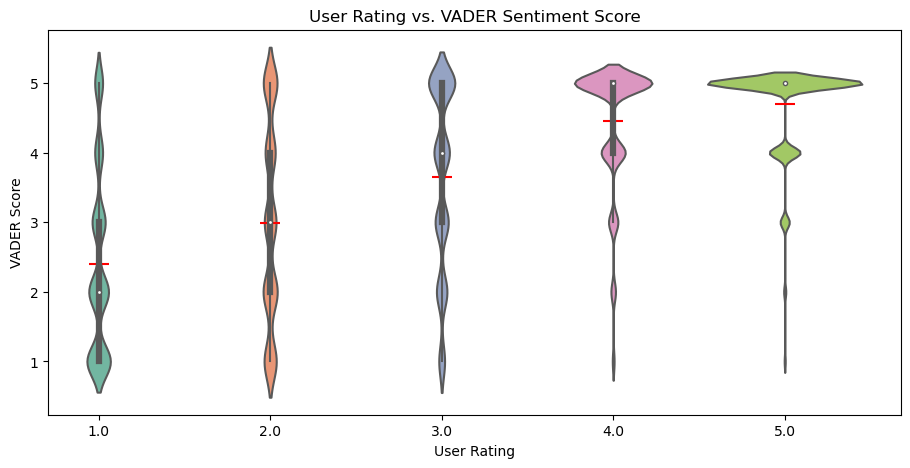

In [317]:
fig, ax = plt.subplots(figsize=(11,5))
sns.set_palette('Set2')
plot = sns.violinplot(x=user, 
             y=vader,
             width=.9,
             density_norm='count')
plot.set(xlabel='User Rating', 
         ylabel='VADER Score',
         title='User Rating vs. VADER Sentiment Score')
plt.scatter(x=range(len(vader_means)),y=vader_means, c='red', marker='_', s=200)


## Vectorization and Clustering
#### 1. Word Embedding with fastText

In [117]:
# create a text file from the cleaned reviews to use to train the fastText model

#reviews['reviewText_clean'].to_csv('../project_data/reviews_clean.txt', header=False, index=False, sep='\n')

In [23]:
# training fasttext model

corpus = '../project_data/reviews_clean.txt'

model = FastText(vector_size=200,
                 sg=1)

model.build_vocab(corpus_file=corpus)

model.train(corpus_file=corpus,
            epochs=model.epochs,
            total_examples=model.corpus_count,
            total_words=model.corpus_total_words)

print(model)

FastText<vocab=9373, vector_size=200, alpha=0.025>


#### 2. Clustering with HDBSCAN

In [82]:
# methods to help create document embeddings from the fastText model by averaging the word vectors of words in a sentence

def get_word_embed(word):
    try:
        return model.wv[word]
    except KeyError:
        return np.zeros(model.vector_size)

def doc_embed(text):
    tokens = text.split()
    embeddings = [get_word_embed(token) for token in tokens]
    embeddings = [emb for emb in embeddings if np.any(emb)]
    if embeddings:
        return np.mean(embeddings, axis=0)
    return np.zeros(model.vector_size)

In [89]:
reviews.dropna(subset=['reviewText_clean_nostpwrds'], inplace=True)
reviews.reset_index(inplace=True,drop=True)

In [90]:
texts = reviews['reviewText_clean_nostpwrds']

for i in range(0,len(texts)):
    if isinstance(texts[i],float):
        print(i)
        print(texts[i])

In [92]:
# creating the document embeddings

reviews = pd.read_csv('../project_data/reviews_final_dataset2.csv')

documents = [doc for doc in reviews['reviewText_clean_nostpwrds']]
doc_embeddings = [doc_embed(doc) for doc in documents]
embedding_array = np.array(doc_embeddings)

In [93]:
# creating the clusterings on the document embeddings using HDBSCAN, three models were created using different parameters:
# 1. default parameters (min_cluster_size = 5, min_samples = 0)
# 2. min_cluster_size = 10, min_samples = 5
# 3. min_cluster_size = 20, min_samples = 10

clusterer = hdbscan.HDBSCAN(gen_min_span_tree=True, core_dist_n_jobs=8)
review_clusters = clusterer.fit(embedding_array)

In [94]:
# save the model

with open('../project_data/hdbscan_model6_def_params.pickle', 'wb') as f:
    pickle.dump(review_clusters,f)

In [10]:
# read in a saved model

# with open('../project_data/hdbscan_model1_def_params.pickle', 'rb') as f:
#     review_clusters = pickle.load(f)

In [95]:
# reading in each of the three saved models to compare their relative validity (higher = better, relative to other models)
# model1: 0.3135576299460738
# model2: 0.30914292473577404
# model3: 0.30405993551429245

# the model with default parameters will be used for analysis

review_clusters.relative_validity_

0.33539873317466423

In [96]:
# clustering with the default parameters produces 243 clusters, plus 1 group of points not assigned to a cluster (noise)

review_clusters.labels_.max()

293

In [97]:
# adding assigned cluster to rows

reviews['cluster'] = review_clusters.labels_

In [123]:
# cluster sizes

cluster_sizes = reviews.groupby('cluster').size().rename('samples')

cluster_counts = pd.DataFrame(cluster_sizes)

cluster_counts.sort_values(by=['samples'])

,samples
cluster,
171,5
198,5
199,5
206,5
139,5
...,...
76,363
153,372
75,388


In [100]:
# adding column of compound scores to reviews df

def retrieve_compound(dict):
    score = dict.get('compound')
    return score

reviews['vader_compound'] = reviews['sentiment'].apply(lambda x: retrieve_compound(x))

In [101]:
# extract keywords from clusters
stop_words = list(text.ENGLISH_STOP_WORDS)

tfidf = TfidfVectorizer(stop_words=stop_words)

results = []

grouped = reviews.groupby('cluster')

# Iterate through each cluster
for cluster, data in grouped:
    non_stopwords_docs = [doc for doc in data['reviewText_clean_nostpwrds'] if any(word not in stop_words for word in doc.split())]

    if non_stopwords_docs:
        tfidf_matrix = tfidf.fit_transform(non_stopwords_docs)

        feature_names = tfidf.get_feature_names_out()

        scores = tfidf_matrix.sum(axis=0).A1
        top_keyword_indices = scores.argsort()[-10:][::-1]  

        top_keywords = [feature_names[i] for i in top_keyword_indices]

        avg_numerical_value = data['vader_compound'].mean()

        results.append({
            'cluster': cluster,
            'keywords': ', '.join(top_keywords),
            'vader_compound': avg_numerical_value
        })

results_df = pd.DataFrame(results)

In [112]:
pd.set_option('max_colwidth', 400)
results_df.sort_values(by=['vader_compound']).head(15)

,cluster,keywords,vader_compound
37,36,"broken, arrived, unusable, parts",-0.511229
30,29,"broken, small, cup",-0.476700
26,25,"uncomfortable, uncomfotable",-0.422494
67,66,"months, broke, month",-0.421500
81,80,"broke, week, month, months, weeks, days, uu, product, owning",-0.421500
82,81,"seat, hard, nice, cushion",-0.181257
51,50,"cheaply, comfortable",-0.044700
54,53,"pay, ok, kinda, guess, alright",-0.030050
55,54,"confortable, effortable",-0.022769
18,17,"returned, unopened",0.000000


In [114]:
results_df.sort_values(by=['vader_compound']).tail(15)

,cluster,keywords,vader_compound
213,213,"value, great, comfortable",0.881420
196,196,"lumbar, support, great, comfortable, good, supporters, stable, nice, love",0.884071
218,218,"great, price, love",0.885114
258,258,"great, comfortable, looks, easy, assemble, nice, comfy, good, really, love",0.885400
263,263,"comfortable, super, easy, assemble, great, comfy",0.889273
271,271,"great, easy, comfortable, assemble",0.889637
270,270,"great, easy, comfortable, assemble",0.891100
252,252,"great, office, home, easy, comfortable, looks, good, assemble, beautiful, super",0.892367
221,221,"price, love, comfortable, great, good",0.892833
290,290,"great, easy, comfortable",0.893400


In [115]:
reviews.loc[reviews['cluster'] == 50]['reviewText']

15001                           Cheaply made
15181                     Very Cheaply made.
19819    too cheaply made ,,not comfortable.
32579                          Cheaply made.
45409                           Cheaply made
46042                          cheaply made.
46704                           cheaply made
54707                           Cheaply made
70380                   Very cheaply made...
Name: reviewText, dtype: object

Q1 quantile of arr :  22.0


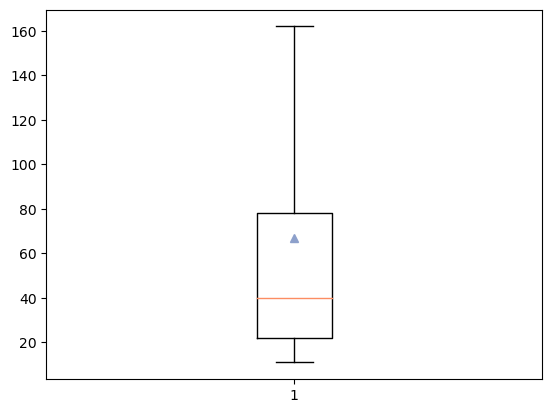

In [289]:
lengths = []

for text in reviews_long['reviewText_clean']:
    lengths.append(len(text.split()))

plt.boxplot(lengths, showfliers=False, showmeans=True)
print("Q1 quantile of arr : ", np.quantile(lengths, .25))
plt.show()

In [306]:
# re-running the document embeddings and clusters with only reviews w/ word count greater than 5, above the 1st quartile

def word_count(text):
    return len(text.split())

reviews_long = reviews.loc[reviews['reviewText_clean'].apply(lambda x: word_count(x) > 5)]

In [307]:
reviews_long.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64319 entries, 0 to 72901
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   asin               64319 non-null  object 
 1   reviewerID         64319 non-null  object 
 2   overall            64319 non-null  float64
 3   summary            64315 non-null  object 
 4   reviewText         64319 non-null  object 
 5   sentiment          64319 non-null  object 
 6   vader_norm_scores  64319 non-null  float64
 7   reviewText_clean   64319 non-null  object 
 8   cluster            64319 non-null  int64  
 9   vader_compound     64319 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 5.4+ MB


In [308]:
documents = [doc for doc in reviews_long['reviewText_clean']]
doc_embeddings = [doc_embed(doc) for doc in documents]
embedding_array = np.array(doc_embeddings)

In [309]:
# running model on new dataset

clusterer = hdbscan.HDBSCAN(gen_min_span_tree=True, core_dist_n_jobs=8)
review_clusters = clusterer.fit(embedding_array)

In [310]:
with open('../project_data/hdbscan_model4_reduced_data_def_params.pickle', 'wb') as f:
    pickle.dump(review_clusters,f)

In [311]:
review_clusters.relative_validity_

0.2833738616302906

In [312]:
review_clusters.labels_.max()

47

In [321]:
reviews_long['cluster'] = review_clusters.labels_

C:\Users\nicho\AppData\Local\Temp\ipykernel_34424\659304753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_long['cluster'] = review_clusters.labels_


In [323]:
def retrieve_compound(dict):
    score = dict.get('compound')
    return score

reviews_long['vader_compound'] = reviews_long['sentiment'].apply(lambda x: retrieve_compound(x))

C:\Users\nicho\AppData\Local\Temp\ipykernel_34424\231787998.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_long['vader_compound'] = reviews_long['sentiment'].apply(lambda x: retrieve_compound(x))


In [325]:
cluster_groups = reviews_long.groupby('cluster')

sample_counts = cluster_groups.size().rename('counts')

avg_vader = cluster_groups['vader_compound'].mean().rename('vader_compound')

cluster_df = pd.concat([sample_counts,avg_vader], axis=1)

In [347]:
# cluster_df.sort_values(by=['vader_compound'])

In [1]:
docs = reviews_long.loc[reviews_long['cluster'] == 47]['reviewText_clean']

with open('../project_data/cluster.txt', 'w') as file:
    for doc in docs:
        file.write(doc+'\n')

NameError: name 'reviews_long' is not defined

In [349]:
max_clusters = 100
min_clusters=5
best_clusters = 0

In [350]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Determine optimal number of clusters using silhouette coefficient
best_score = -1
scoreList = {}
bestRandomSeed = -1
count_dict = {}
def increment_count(key):
    if key in count_dict:
        count_dict[key] += 1
    else:
        count_dict[key] = 1

for randomSeed in range(0,1):#ran 50 to test
    bestSeedScore=-1
    bestCluster=-1
    for n_clusters in range(min_clusters, max_clusters+1):
        # Create a KMeans model with the current number of clusters
        kmeans = KMeans(n_clusters=n_clusters, random_state=randomSeed)
        
        # Fit the KMeans model to the TF-IDF features
        kmeans.fit(embedding_array)
        
        # Predict the cluster labels for the TF-IDF features
        labels = kmeans.labels_
        
        # Calculate the silhouette score for the clustering result
        score = silhouette_score(embedding_array, labels)
        scoreList[n_clusters]=score
        # Update the best score and number of clusters if necessary
        if score > bestSeedScore:
            bestSeedScore=score
            bestCluster=n_clusters
        if score > best_score:
            bestRandomSeed = randomSeed
            best_score = score
            best_clusters = n_clusters
    increment_count(bestCluster)
        

# Print the optimal number of clusters
print("Optimal number of clusters:", best_clusters)

# Perform clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=best_clusters, random_state=bestRandomSeed)
kmeans.fit(embedding_array)

# Get the cluster labels for each document
cluster_labels = kmeans.labels_

# Add the cluster labels to the DataFrame
reviews_long['cluster'] = cluster_labels

# Display the resulting DataFrame
print(scoreList)

c:\Users\nicho\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\nicho\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\nicho\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\nicho\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 
